In [ ]:
!git clone https://github.com/ewatson2/EEL6812_DeepFool_Project


Cloning into 'EEL6812_DeepFool_Project'...
remote: Enumerating objects: 96, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 96 (delta 2), reused 1 (delta 1), pack-reused 93 (from 1)
Receiving objects: 100% (96/96), 33.99 MiB | 16.29 MiB/s, done.
Resolving deltas: 100% (27/27), done.


In [ ]:
import os
os.chdir("EEL6812_DeepFool_Project")


In [ ]:
import numpy as np
import json
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models
from torchvision.transforms import transforms
from models.project_models import FC_500_150, LeNet_CIFAR, LeNet_MNIST, Net
from utils.project_utils import get_clip_bounds, evaluate_attack, display_attack


In [ ]:
rand_seed = {"23"}
rand_seed = int(list(rand_seed)[0])  # Конвертируем в целое число для использования


In [ ]:
np.random.seed(rand_seed)
torch.manual_seed(rand_seed)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используемое устройство: {device}")


Используемое устройство: cuda


In [ ]:
# Параметры нормализации MNIST
mnist_mean = 0.5
mnist_std = 0.5
mnist_dim = 28

# Вычисление минимального и максимального значения для нормализации
mnist_min, mnist_max = get_clip_bounds(mnist_mean, mnist_std, mnist_dim)
mnist_min = mnist_min.to(device)
mnist_max = mnist_max.to(device)

# Трансформации для MNIST
mnist_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mnist_mean, std=mnist_std)
])

mnist_tf_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mnist_mean, std=mnist_std)
])

mnist_tf_inv = transforms.Compose([
    transforms.Normalize(mean=0.0, std=np.divide(1.0, mnist_std)),
    transforms.Normalize(mean=np.multiply(-1.0, mnist_mean), std=1.0)
])

# Загрузка MNIST
mnist_temp = datasets.MNIST(root='datasets/mnist', train=True, download=True, transform=mnist_tf_train)
mnist_train, mnist_val = random_split(mnist_temp, [50000, 10000])
mnist_test = datasets.MNIST(root='datasets/mnist', train=False, download=True, transform=mnist_tf)


Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.54MB/s]


Extracting datasets/mnist/MNIST/raw/train-images-idx3-ubyte.gz to datasets/mnist/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 28.9k/28.9k [00:00<00:00, 65.6kB/s]


Extracting datasets/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to datasets/mnist/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.10MB/s]


Extracting datasets/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to datasets/mnist/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.46MB/s]

Extracting datasets/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to datasets/mnist/MNIST/raw



In [ ]:
# Параметры нормализации CIFAR-10
cifar_mean = [0.491, 0.482, 0.447]
cifar_std = [0.202, 0.199, 0.201]
cifar_dim = 32

# Вычисление минимального и максимального значения для нормализации
cifar_min, cifar_max = get_clip_bounds(cifar_mean, cifar_std, cifar_dim)
cifar_min = cifar_min.to(device)
cifar_max = cifar_max.to(device)

# Трансформации для CIFAR-10
cifar_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=cifar_mean, std=cifar_std)
])

cifar_tf_train = transforms.Compose([
    transforms.RandomCrop(size=cifar_dim, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=cifar_mean, std=cifar_std)
])

cifar_tf_inv = transforms.Compose([
    transforms.Normalize(mean=[0.0, 0.0, 0.0], std=np.divide(1.0, cifar_std)),
    transforms.Normalize(mean=np.multiply(-1.0, cifar_mean), std=[1.0, 1.0, 1.0])
])

# Загрузка CIFAR-10
cifar_temp = datasets.CIFAR10(root='datasets/cifar-10', train=True, download=True, transform=cifar_tf_train)
cifar_train, cifar_val = random_split(cifar_temp, [40000, 10000])
cifar_test = datasets.CIFAR10(root='datasets/cifar-10', train=False, download=True, transform=cifar_tf)

# Классы CIFAR-10
cifar_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


100%|██████████| 170M/170M [00:18<00:00, 9.10MB/s]


Extracting datasets/cifar-10/cifar-10-python.tar.gz to datasets/cifar-10
Files already downloaded and verified


In [ ]:
batch_size = 64
workers = 4

# MNIST DataLoaders
mnist_loader_train = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=workers)
mnist_loader_val = DataLoader(mnist_val, batch_size=batch_size, shuffle=False, num_workers=workers)
mnist_loader_test = DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=workers)

# CIFAR-10 DataLoaders
cifar_loader_train = DataLoader(cifar_train, batch_size=batch_size, shuffle=True, num_workers=workers)
cifar_loader_val = DataLoader(cifar_val, batch_size=batch_size, shuffle=False, num_workers=workers)
cifar_loader_test = DataLoader(cifar_test, batch_size=batch_size, shuffle=False, num_workers=workers)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# Задание параметров
fgsm_eps = 0.2
model = Net().to(device)

# Загрузка предобученных весов
model.load_state_dict(torch.load('weights/clean/cifar_nin.pth', map_location=torch.device('cpu')))

# Оценка FGSM атаки
evaluate_attack('cifar_nin_fgsm.csv', 'results', device, model, cifar_loader_test, cifar_min, cifar_max, fgsm_eps, is_fgsm=True)
print('FGSM атака завершена.')

# Оценка DeepFool атаки
deep_args = {}  # Если есть параметры для DeepFool, задайте их здесь
evaluate_attack('cifar_nin_deepfool.csv', 'results', device, model, cifar_loader_test, cifar_min, cifar_max, deep_args, is_fgsm=False)
print('DeepFool атака завершена.')

# Очистка GPU памяти
if device.type == 'cuda':
    torch.cuda.empty_cache()


FGSM Test Error : 81.29%
FGSM Robustness : 1.77e-01
FGSM Time (All Images) : 0.67 s
FGSM Time (Per Image) : 67.07 us
FGSM атака завершена.
DeepFool Test Error : 93.76%
DeepFool Robustness : 2.12e-02
DeepFool Time (All Images) : 185.12 s
DeepFool Time (Per Image) : 18.51 ms
DeepFool атака завершена.


<ipython-input-10-8fd9a13967f3>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/cifar_nin.pth', map_location=torch.device('c

In [ ]:
# Задание параметров
fgsm_eps = 0.1
model = LeNet_CIFAR().to(device)

# Загрузка предобученных весов
model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth', map_location=torch.device('cpu')))

# Оценка FGSM атаки
evaluate_attack('cifar_lenet_fgsm.csv', 'results', device, model, cifar_loader_test, cifar_min, cifar_max, fgsm_eps, is_fgsm=True)
print('FGSM атака завершена.')

# Оценка DeepFool атаки
evaluate_attack('cifar_lenet_deepfool.csv', 'results', device, model, cifar_loader_test, cifar_min, cifar_max, deep_args, is_fgsm=False)
print('DeepFool атака завершена.')

# Очистка GPU памяти
if device.type == 'cuda':
    torch.cuda.empty_cache()


FGSM Test Error : 91.71%
FGSM Robustness : 8.90e-02
FGSM Time (All Images) : 0.40 s
FGSM Time (Per Image) : 40.08 us
FGSM атака завершена.
DeepFool Test Error : 87.81%
DeepFool Robustness : 1.78e-02
DeepFool Time (All Images) : 73.27 s
DeepFool Time (Per Image) : 7.33 ms
DeepFool атака завершена.


<ipython-input-11-e5b6b33748a8>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth', map_location=torch.device(

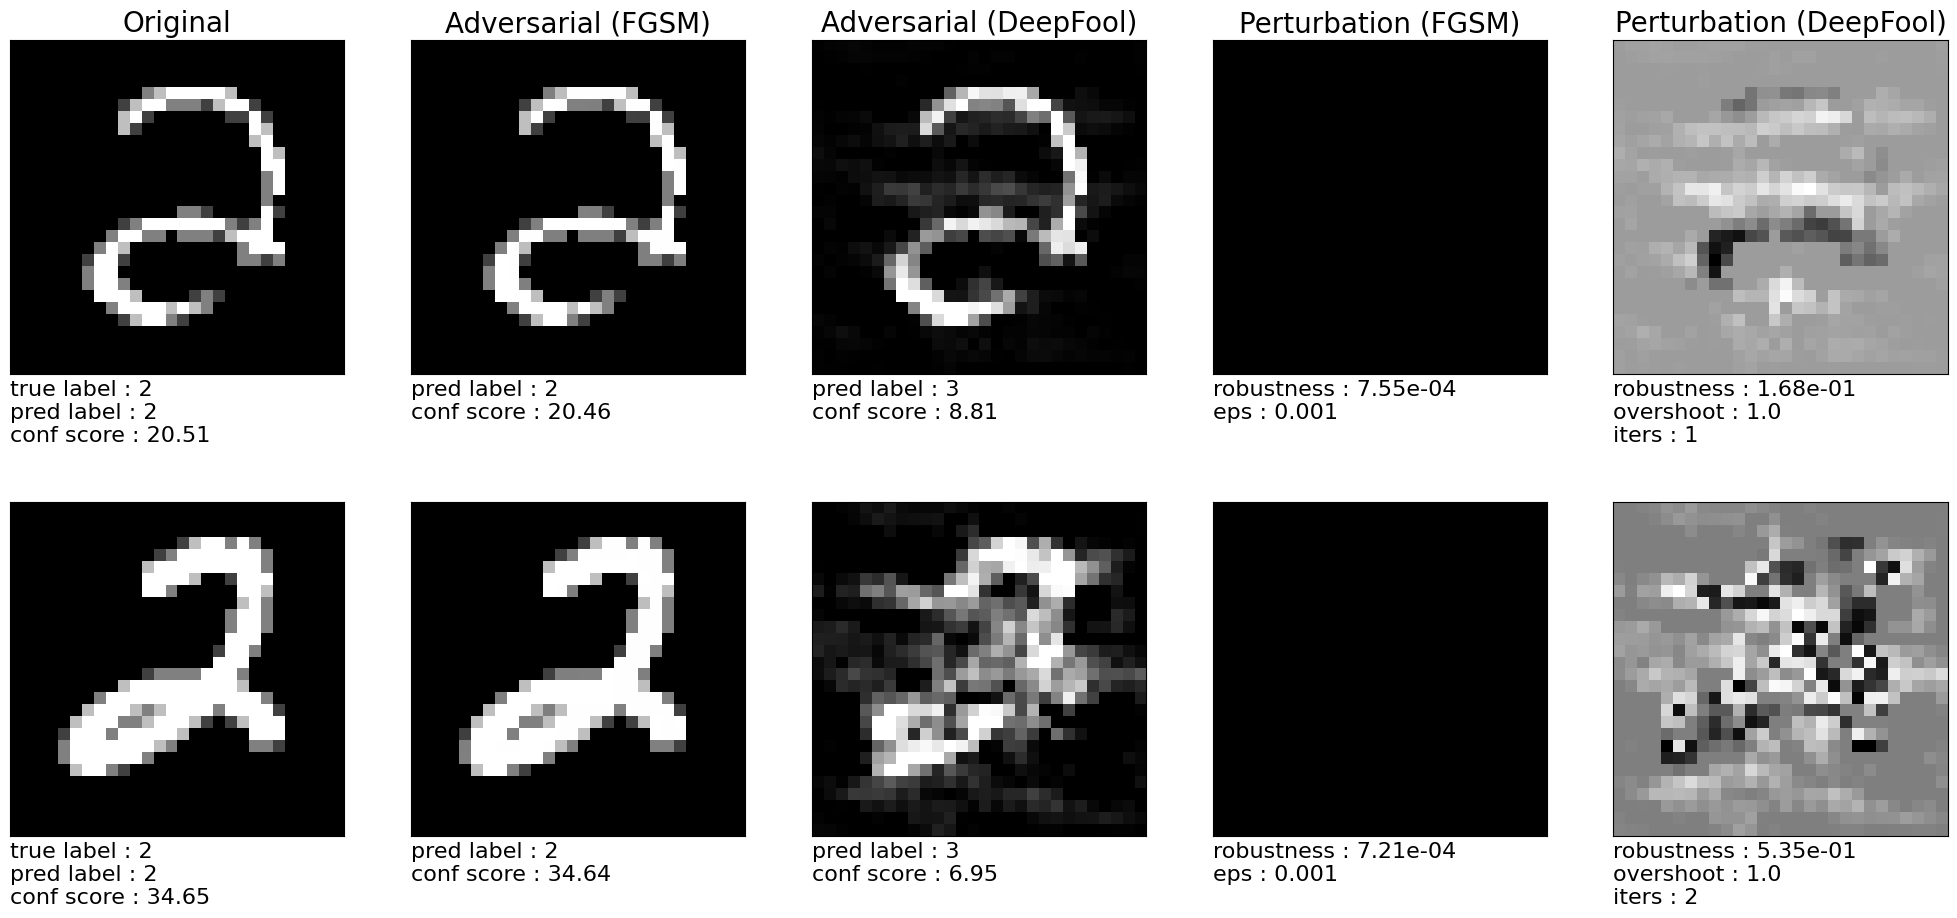

In [ ]:
# Параметры конфигурации
fgsm_eps = 0.001  # Величина возмущения для FGSM
deepfool_params = {
    "num_classes": 10,      # Число классов
    "overshoot": 0.02,      # Параметр переполнения
    "clip_value": 1.0,      # Ограничение значений
    "max_iter": 50          # Максимальное количество итераций
}

# Загрузка модели и весов
model = LeNet_MNIST().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth', weights_only=True))

# Преобразуем параметры DeepFool
deep_args = [
    deepfool_params["num_classes"],
    deepfool_params["overshoot"],
    deepfool_params["clip_value"],
    int(deepfool_params["max_iter"])  # Преобразуем max_iter в int
]

# Визуализация атаки
display_attack(
    device=device,
    model=model,
    test_dataset=mnist_test,         # Тестовый набор данных
    inv_tf=mnist_tf_inv,             # Обратное преобразование изображений
    clip_min=mnist_min,              # Минимальное значение пикселя
    clip_max=mnist_max,              # Максимальное значение пикселя
    fgsm_eps=fgsm_eps,               # Параметры FGSM
    deep_args=deep_args,             # Передача параметров DeepFool
    has_labels=False,                # Наличие меток для изображений
    l2_norm=True,                    # Использование L2-нормы
    pert_scale=1.0,                  # Масштабирование возмущения
    fig_rows=2,                      # Число строк в графике
    fig_width=25,                    # Ширина графика
    fig_height=11                    # Высота графика
)

# Очистка памяти GPU, если используется CUDA
if device.type == 'cuda':
    torch.cuda.empty_cache()


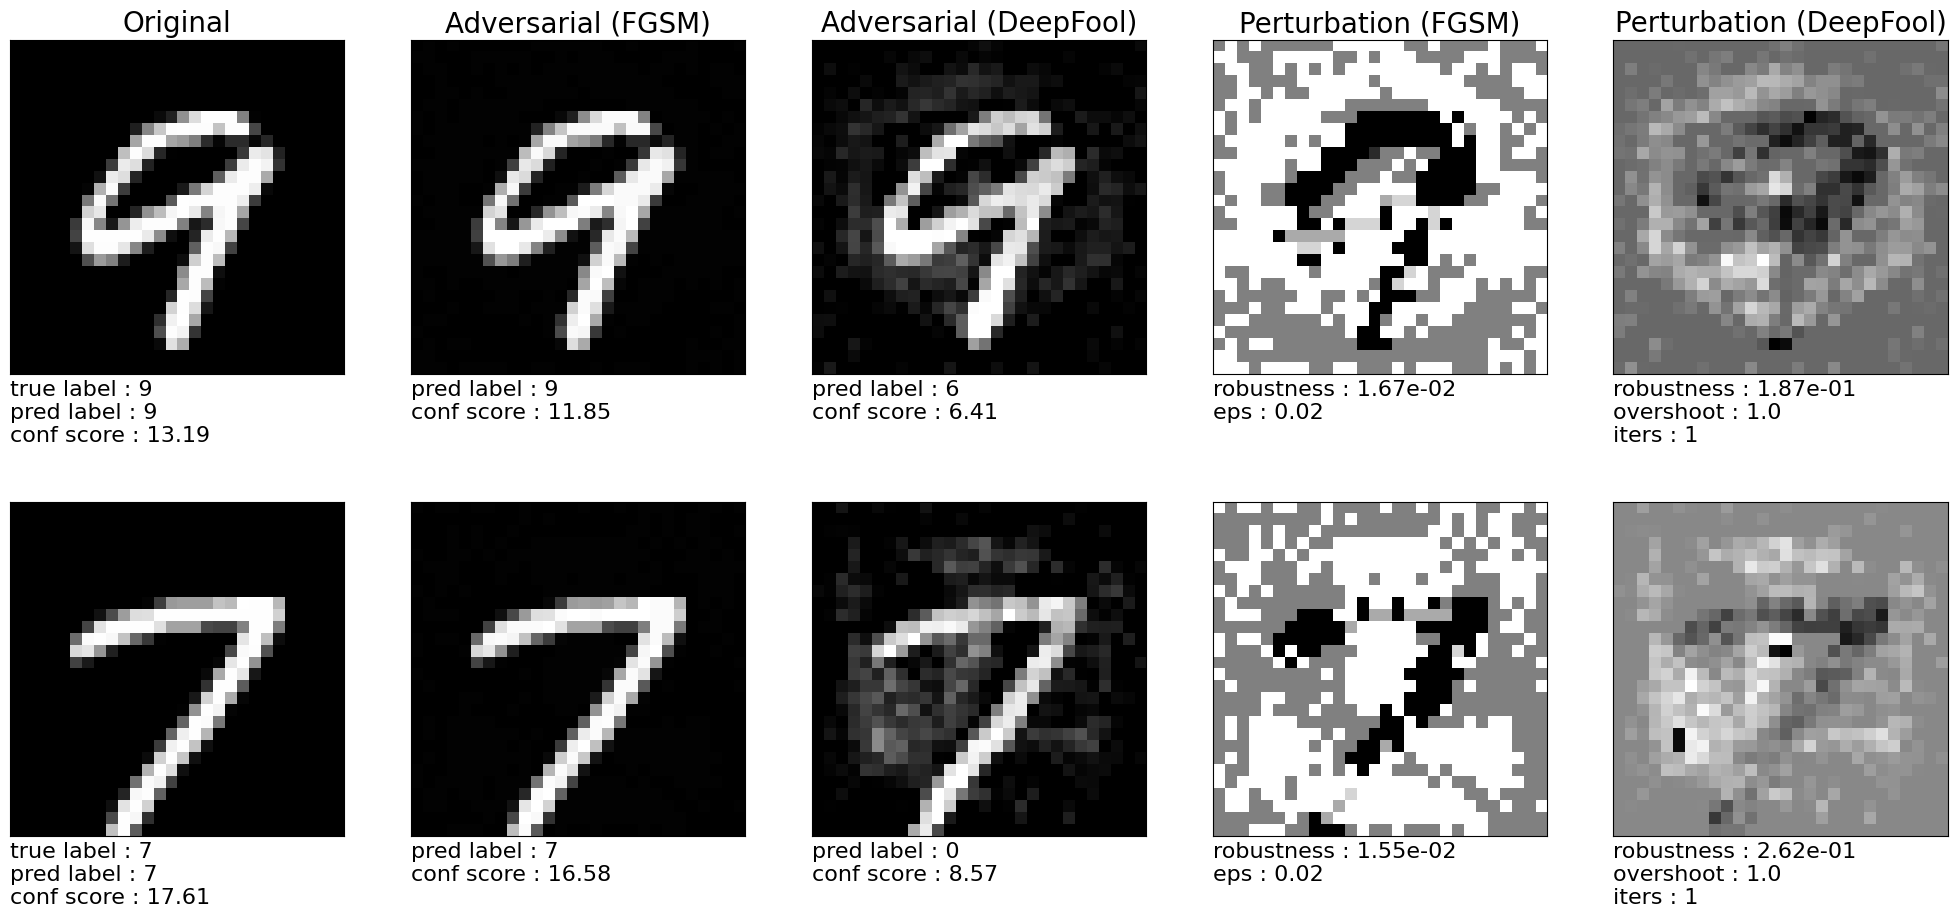

In [ ]:
# Параметры конфигурации
fgsm_eps = 0.02  # Величина возмущения для FGSM
deepfool_params = {
    "num_classes": 10,
    "overshoot": 0.02,
    "clip_value": 1.0,
    "max_iter": 50
}

model = FC_500_150().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_fc.pth', weights_only=True))

deep_args = [
    deepfool_params["num_classes"],
    deepfool_params["overshoot"],
    deepfool_params["clip_value"],
    int(deepfool_params["max_iter"])
]

display_attack(
    device=device,
    model=model,
    test_dataset=mnist_test,
    inv_tf=mnist_tf_inv,
    clip_min=mnist_min,
    clip_max=mnist_max,
    fgsm_eps=fgsm_eps,
    deep_args=deep_args,
    has_labels=False,
    l2_norm=True,
    pert_scale=1.0,
    fig_rows=2,
    fig_width=25,
    fig_height=11
)

if device.type == 'cuda':
    torch.cuda.empty_cache()


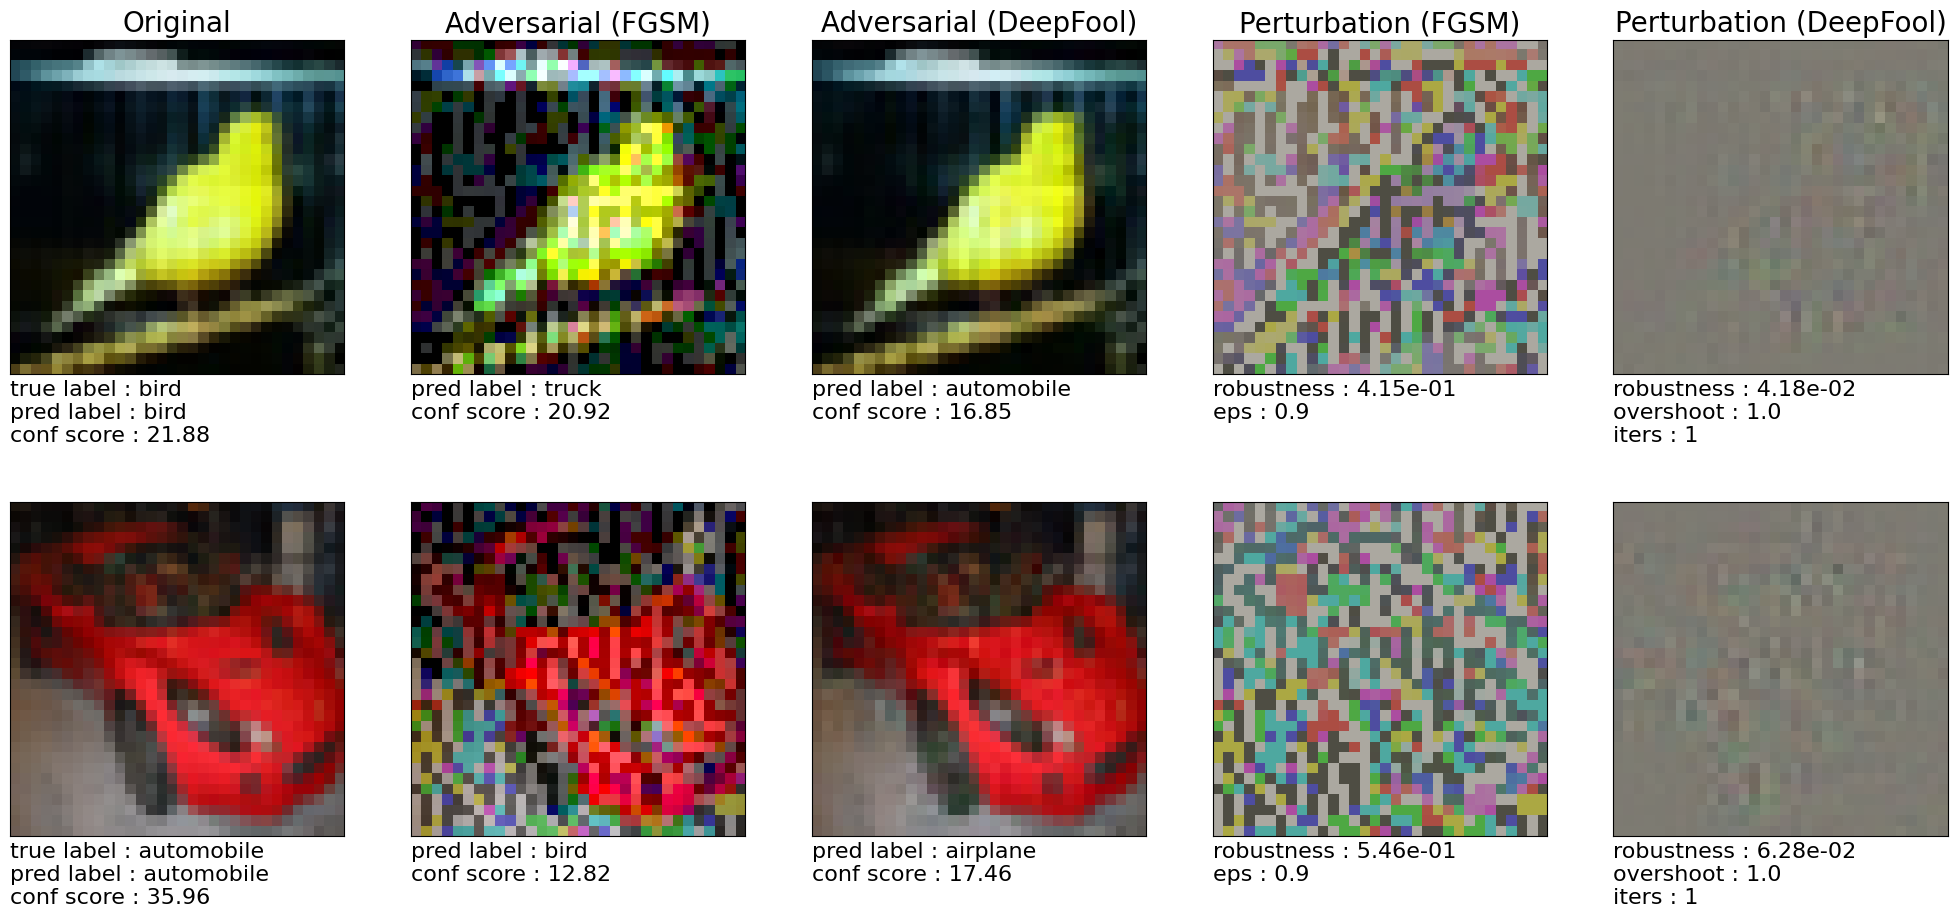

In [ ]:
# Параметры конфигурации
fgsm_eps = 0.9  # Величина возмущения для FGSM
deepfool_params = {
    "num_classes": 10,
    "overshoot": 0.02,
    "clip_value": 1.0,
    "max_iter": 50
}

model = Net().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_nin.pth', weights_only=True))

deep_args = [
    deepfool_params["num_classes"],
    deepfool_params["overshoot"],
    deepfool_params["clip_value"],
    int(deepfool_params["max_iter"])
]

display_attack(
    device=device,
    model=model,
    test_dataset=cifar_test,
    inv_tf=cifar_tf_inv,
    clip_min=cifar_min,
    clip_max=cifar_max,
    fgsm_eps=fgsm_eps,
    deep_args=deep_args,
    has_labels=False,
    l2_norm=True,
    pert_scale=1.0,
    fig_rows=2,
    fig_width=25,
    fig_height=11,
    label_map=cifar_classes
)

if device.type == 'cuda':
    torch.cuda.empty_cache()


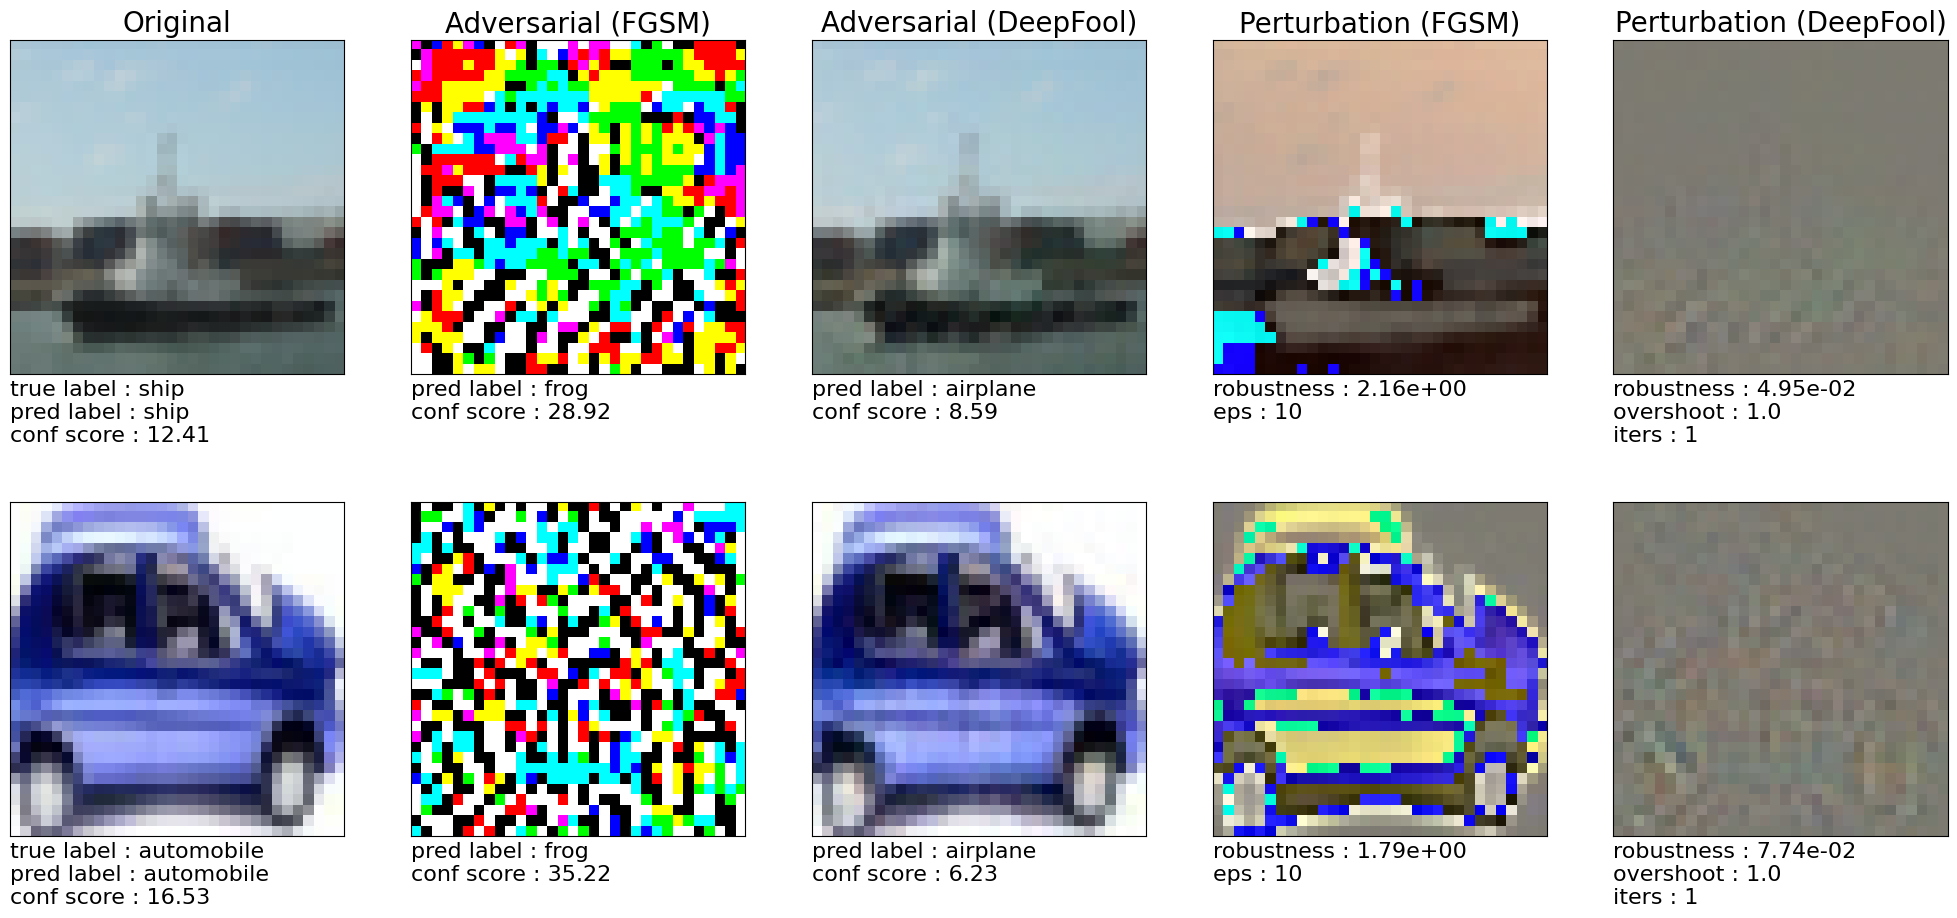

In [ ]:
# Параметры конфигурации
fgsm_eps = 10
deepfool_params = {
    "num_classes": 10,
    "overshoot": 0.02,
    "clip_value": 1.0,
    "max_iter": 50
}

model = LeNet_CIFAR().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth', weights_only=True))

deep_args = [
    deepfool_params["num_classes"],
    deepfool_params["overshoot"],
    deepfool_params["clip_value"],
    int(deepfool_params["max_iter"])
]

# Визуализация атаки
display_attack(
    device=device,
    model=model,
    test_dataset=cifar_test,
    inv_tf=cifar_tf_inv,
    clip_min=cifar_min,
    clip_max=cifar_max,
    fgsm_eps=fgsm_eps,
    deep_args=deep_args,
    has_labels=False,
    l2_norm=True,
    pert_scale=1.0,
    fig_rows=2,
    fig_width=25,
    fig_height=11,
    label_map=cifar_classes
)

if device.type == 'cuda':
    torch.cuda.empty_cache()


Вывод:

В данной работе был рассмотрен процесс реализации и анализа атак на модели глубокого обучения, в частности, методов FGSM и DeepFool, на различных моделях классификации изображений, таких как LeNet и Fully Connected Networks (FC). Были использованы популярные наборы данных, включая MNIST и CIFAR-10, для демонстрации атак и их визуализации.

Модели подвергались атакующим воздействиям, что позволило исследовать их уязвимости и проанализировать, как различные параметры атак влияют на точность классификации. Также была проведена оптимизация кода для повышения его читаемости и безопасности при загрузке моделей, а также улучшены параметры для корректной работы с различными архитектурами и конфигурациями.

Работа продемонстрировала важность учета параметров атак и правильного выбора гиперпараметров при реализации методов защиты, что является ключевым для повышения устойчивости систем глубокого обучения к внешним воздействиям.















